In [1]:
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import scipy
import scipy.stats

In [2]:
def cmf(pmf,axis=None):
    if axis is None:
        return np.concatenate([[0], np.cumsum(pmf)])
    else:
        shape = np.shape(pmf)
        z_shape = np.copy(shape)
        z_shape[axis] = 1
        z = np.zeros(z_shape)
        return np.concatenate([z, np.cumsum(pmf, axis=axis)], axis=axis)
def pmf(cmf, axis=-1):
    return np.diff(cmf, axis=axis)
def interp(x, x0, x1, y0, y1):
    r = np.empty(shape=np.shape(x))
    mask_0 = x == x0
    mask_1 = x == x1
    mask_2 = ~np.logical_or(mask_0, mask_1)
    r[mask_0] = y0[mask_0]
    r[mask_1] = y1[mask_1]
    r[mask_2] = y0[mask_2]+(x[mask_2]-x0[mask_2])*(y1[mask_2]-y0[mask_2])/(x1[mask_2]-x0[mask_2])
    return r

In [3]:
def cmf_interp_helper(cmf_0, edges_0, y_val, i_0):
    x0s = []
    # Determine where we are with respect to cmf_0
    while i_0 < len(cmf_0)-1 and cmf_0[i_0] < y_val:
        i_0 += 1
    # cmf[i_0] is greater than or equal to y_val
    if cmf_0[i_0] == y_val:
        # Check for duplicate values
        i_0_upper = i_0
        while i_0_upper < len(cmf_0)-1 and cmf_0[i_0_upper] == y_val:
            i_0_upper += 1
        i_0_upper -= 1
        if i_0 == i_0_upper:
            # We don't have duplicate values
            x0s.append(edges_0[i_0])
        else:
            # We have duplicate values
            x0s.append(edges_0[i_0])
            x0s.append(edges_0[i_0_upper])
    else:
        # Use cmf_0[i_0 - 1] for interpolation
        x0 = interp(y_val, cmf_0[i_0-1], cmf_0[i_0], edges_0[i_0-1], edges_0[i_0])
        x0s.append(x0)
    return x0s, i_0

def compute_interp_cmf(cmf_0, cmf_1, edges_0, edges_1, x):
    y_vals = np.unique(np.concatenate([cmf_0, cmf_1]))
    i_0 = 0
    i_1 = 0
    x_pairs = []
    return_y = []
    for y_val in y_vals:
        x0s, i_0 = cmf_interp_helper(cmf_0, edges_0, y_val, i_0)
        x1s, i_1 = cmf_interp_helper(cmf_1, edges_1, y_val, i_1)
        pairs = [(x0, x1) for x0 in x0s for x1 in x1s]
        x_pairs.extend(pairs)
        return_y.extend([y_val]*len(pairs))
    return_x = [x0*(1.0-x) + x1*x for x0, x1 in x_pairs]
    return (np.array(x) for x in zip(*sorted(zip(return_y, return_x), key=lambda x: x[1])))


In [4]:
def rebin_cmf(cmf_0, edges_0, edges_1):
    r = np.empty(shape=len(edges_1))
    mask_less = edges_1 < np.amin(edges_0)
    mask_more = edges_1 >= np.amax(edges_0)
    mask = ~np.logical_or(mask_less, mask_more)
    r[mask_less] = 0.0
    r[mask_more] = 1.0
    
    x_pos = np.digitize(edges_1[mask], bins=edges_0) - 1
    y_vals = interp(edges_1[mask],
           edges_0[x_pos], edges_0[x_pos+1],
           cmf_0[x_pos], cmf_0[x_pos])
    r[mask] = y_vals
    return r

In [5]:
# Prepare test data

bins = np.linspace(0,10,13)

data_3 = np.random.normal(3, 1.0, 100)
data_5 = np.random.normal(5, 1.0, 100)

hist_3 = np.histogram(data_3, bins=bins)[0]
hist_5 = np.histogram(data_5, bins=bins)[0]

pmf_3 = hist_3 / np.sum(hist_3)
pmf_5 = hist_5 / np.sum(hist_5)

cmf_3 = cmf(pmf_3)
cmf_5 = cmf(pmf_5)

[0 0 0 0]
[0.         4.58333333 4.58333333 9.16666667]


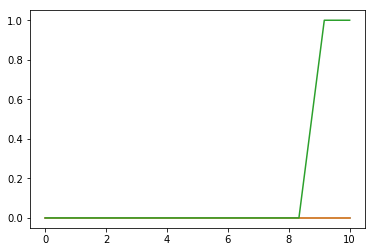

In [6]:
cmf_4, edges_4 = compute_interp_cmf(cmf_3, cmf_5, bins, bins, 0.5)
print(cmf_4)
print(edges_4)
cmf_4 = rebin_cmf(cmf_4, edges_4, bins)
plt.plot(bins, cmf_3)
plt.plot(bins, cmf_5)
plt.plot(bins, cmf_4)

(array([0.  , 0.05, 0.19, 0.32, 0.24, 0.16, 0.03, 0.01, 0.  , 0.  ]),
 array([0.41666667, 1.33333333, 2.25      , 3.16666667, 4.08333333,
        5.        , 5.91666667, 6.83333333, 7.75      , 8.66666667,
        9.58333333]),
 <a list of 1 Patch objects>)

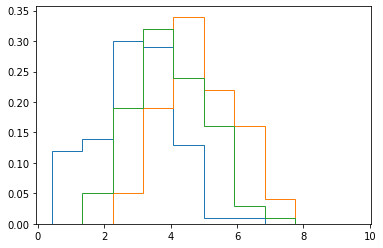

In [7]:
center = lambda x: (x[:-1] + x[1:])/2.0
plt.hist(center(bins), weights=pmf(cmf_3), histtype='step')
plt.hist(center(bins), weights=pmf(cmf_5), histtype='step')
plt.hist(center(bins), weights=pmf(cmf_4), histtype='step')

In [8]:
# Prepare test data

bins = np.linspace(0,10,13)

data_3 = scipy.stats.multivariate_normal.rvs([3,3+1], size=100)
data_5 = scipy.stats.multivariate_normal.rvs([5,5+1], size=100)

hist_3 = np.histogramdd(data_3, bins=[bins,bins])[0]
hist_5 = np.histogramdd(data_5, bins=[bins,bins])[0]

pmf_3 = hist_3 / np.sum(hist_3)
pmf_5 = hist_5 / np.sum(hist_5)

print(pmf_3)

pmf_3_0 = np.sum(pmf_3, axis=1)
pmf_5_0 = np.sum(pmf_5, axis=1)

print(pmf_3_0)

pmf_3_1 = np.sum(pmf_3, axis=0)
pmf_5_1 = np.sum(pmf_5, axis=0)

pmf_3_0p = np.zeros(pmf_3.shape)
np.divide(pmf_3, pmf_3_0[:,None], where=pmf_3_0[:,None] > 0, out=pmf_3_0p)
print(np.sum(pmf_3_0p, axis=1))
pmf_5_0p = np.zeros(pmf_5.shape)
np.divide(pmf_5, pmf_5_0[:,None], where=pmf_5_0[:,None] > 0, out=pmf_5_0p)

pmf_3_1p = np.zeros(pmf_3.shape)
np.divide(pmf_3, pmf_3_1[None,:], where=pmf_3_1[None,:] > 0, out=pmf_3_1p)
pmf_5_1p = np.zeros(pmf_5.shape)
np.divide(pmf_5, pmf_5_1[None,:], where=pmf_5_1[None,:] > 0, out=pmf_5_1p)

cmf_3_0 = cmf(pmf_3_0)
cmf_5_0 = cmf(pmf_5_0)

cmf_3_1 = cmf(pmf_3_1)
cmf_3_1 = cmf(pmf_5_1)

cmf_3_0p = cmf(pmf_3_0p, axis=1)
cmf_5_0p = cmf(pmf_5_0p, axis=1)

cmf_3_1p = cmf(pmf_3_1p, axis=0)
cmf_3_1p = cmf(pmf_5_1p, axis=0)

[[0.   0.   0.   0.   0.   0.01 0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.01 0.02 0.   0.03 0.01 0.   0.   0.   0.   0.  ]
 [0.   0.   0.04 0.06 0.05 0.11 0.03 0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.06 0.04 0.03 0.05 0.   0.   0.   0.   0.  ]
 [0.   0.01 0.04 0.06 0.1  0.04 0.05 0.01 0.   0.   0.   0.  ]
 [0.   0.   0.   0.01 0.02 0.02 0.03 0.   0.   0.   0.   0.  ]
 [0.   0.   0.01 0.01 0.02 0.   0.01 0.01 0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]]
[0.01 0.07 0.29 0.18 0.31 0.08 0.06 0.   0.   0.   0.   0.  ]
[1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]


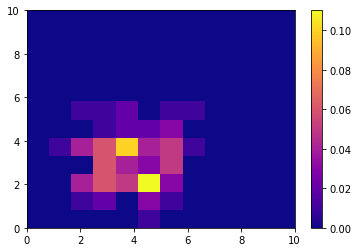

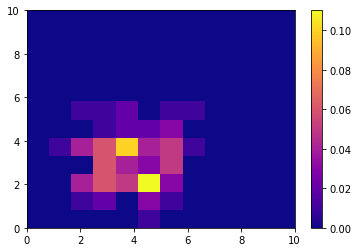

In [9]:
cm = plt.get_cmap('plasma')
X = np.array([bins]*len(bins))
Y = X.T
plt.pcolormesh(X, Y, pmf(cmf_3_0p, axis=1)*(pmf_3_0[:,None]), cmap=cm)
cb = plt.colorbar()
plt.show()

cm = plt.get_cmap('plasma')
X = np.array([bins]*len(bins))
Y = X.T
plt.pcolormesh(X, Y, pmf_3, cmap=cm)
cb = plt.colorbar()
plt.show()

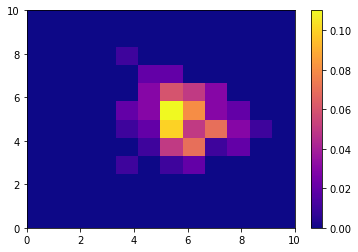

In [10]:
cm = plt.get_cmap('plasma')
X = np.array([bins]*len(bins))
Y = X.T
plt.pcolormesh(X, Y, pmf_5, cmap=cm)
cb = plt.colorbar()